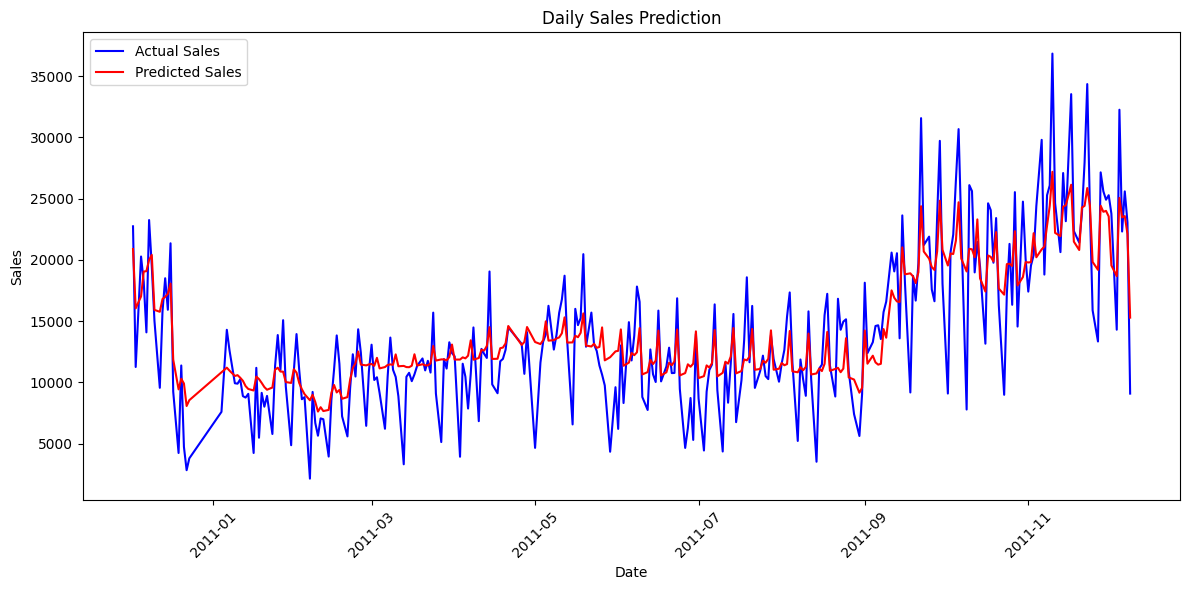

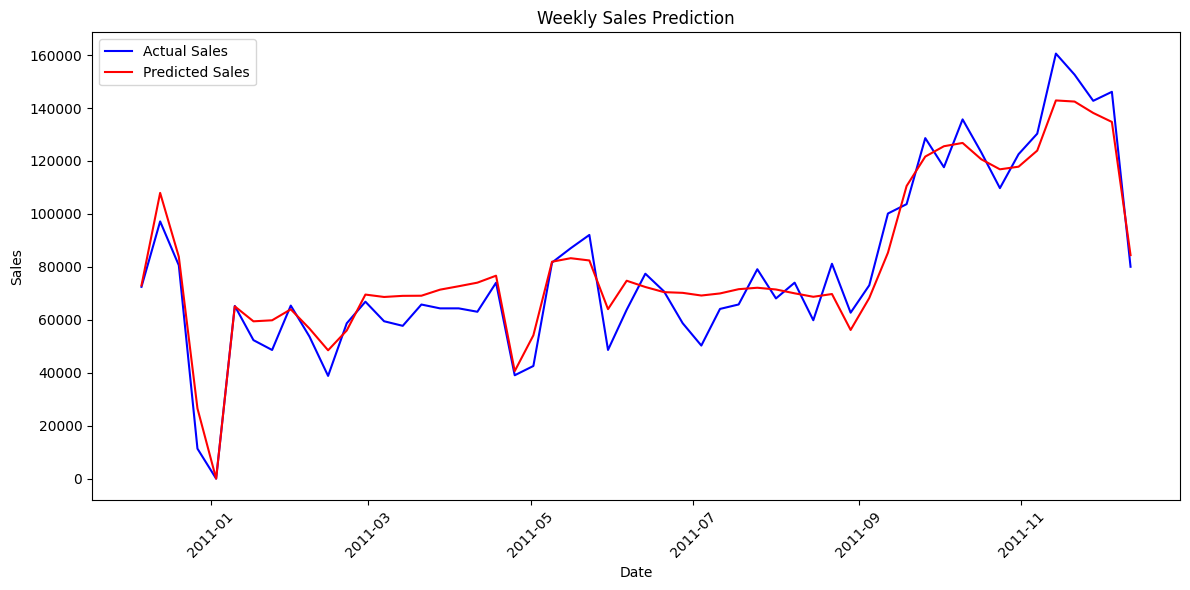

C:\Users\bryan\AppData\Local\Temp\ipykernel_7036\3895579469.py:97: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_data = daily_sales_data.resample('M', on='Date').sum().reset_index()


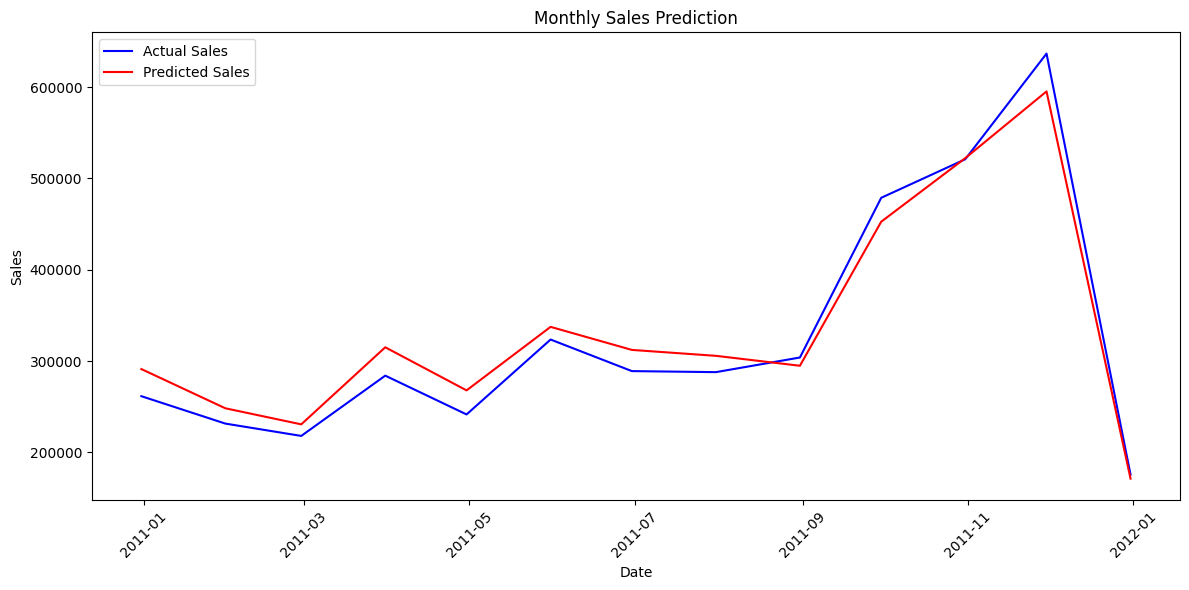

In [2]:
import pandas as pd
import numpy as np
import joblib  # For loading the saved model
from sqlalchemy import create_engine  # For connecting to the database
from dotenv import load_dotenv  # For loading environment variables
import os
import matplotlib.pyplot as plt  # For plotting graphs

# Load environment variables
load_dotenv()

# Set up the database connection using environment variables
db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)

# Load the trained Random Forest model with error handling
model_path = 'sales_forecasting_rf_model.pkl'
try:
    model = joblib.load(model_path)
except FileNotFoundError:
    raise Exception(f"Model file '{model_path}' not found. Ensure the model is saved in the specified path.")

# SQL Query to fetch the required data
query = """
SELECT
    s.salesid,
    s.customerid,
    s.stockcode,
    s.quantity,
    s.unitprice,
    s.totalprice,
    t.day,
    t.month,
    t.year,
    c.country
FROM
    sales s
JOIN
    time t ON s.timeid = t.timeid
JOIN
    customer c ON s.customerid = c.customerid
"""

# Load the data from the database
df = pd.read_sql(query, engine)

# Create a new column for the date
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Aggregate sales by date to get daily sales data
daily_sales_data = df.groupby('Date').agg({'totalprice': 'sum'}).reset_index()
daily_sales_data['DateNumeric'] = (daily_sales_data['Date'] - pd.Timestamp("1970-01-01")).dt.days

# Feature Engineering for the model
daily_sales_data['day_of_week'] = daily_sales_data['Date'].dt.dayofweek
daily_sales_data['month_of_year'] = daily_sales_data['Date'].dt.month
daily_sales_data['is_weekend'] = daily_sales_data['day_of_week'].isin([5, 6]).astype(int)
daily_sales_data['sales_lag_1'] = daily_sales_data['totalprice'].shift(1)

# Drop rows with NaN values in lagged sales data
daily_sales_data = daily_sales_data.dropna()

# Prepare the features for prediction
X_daily = daily_sales_data[['DateNumeric', 'day_of_week', 'month_of_year', 'is_weekend', 'sales_lag_1']]

# Predict daily sales
daily_sales_data['PredictedSales'] = model.predict(X_daily)

# Function for plotting actual vs predicted sales
def plot_sales(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    # If 'Date' column is not in data, use index for plotting
    if 'Date' in data.columns:
        plt.plot(data['Date'], data['totalprice'], label='Actual Sales', color='blue')
        plt.plot(data['Date'], data['PredictedSales'], label='Predicted Sales', color='red')
    else:
        plt.plot(data.index, data['totalprice'], label='Actual Sales', color='blue')
        plt.plot(data.index, data['PredictedSales'], label='Predicted Sales', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot daily sales predictions
plot_sales(daily_sales_data, 'Daily Sales Prediction', 'Date', 'Sales')

# Weekly Prediction: Resample data to weekly frequency
weekly_sales_data = daily_sales_data.resample('W-MON', on='Date').sum().reset_index()

# Plot weekly sales predictions
plot_sales(weekly_sales_data, 'Weekly Sales Prediction', 'Date', 'Sales')

# Monthly Prediction: Resample data to monthly frequency
monthly_sales_data = daily_sales_data.resample('M', on='Date').sum().reset_index()

# Plot monthly sales predictions
plot_sales(monthly_sales_data, 'Monthly Sales Prediction', 'Date', 'Sales')
